# Regression Refresher Exercises

In [30]:
import arviz as az
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from matplotlib.lines import Line2D

In [5]:
%matplotlib inline
plt.style.use("intuitivebayes.mplstyle")

mpl.rcParams["figure.dpi"] = 120
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.spines.left"] = False

In [6]:
data = pd.read_csv("data/fish-market.csv")
data = data[data["Weight"] > 0].reset_index(drop=True)

## Exercise 1: Create a basic linear regression model

You're asked to build a linear regression model to predict the weight of the fish based on their width. Take the following points into consideration while building your model.

* Are transformations needed? Does it make sense to... 
    * Transform the predictor?
    * Transform the response?
    * Both?
* How many lines of code is it?
* How does the fit of this model compares to the fit of the simple model we created in the lesson?

In addition, this is the opportunity to be creative. You can try other transformations and custom visualizations as well. 

Have fun!

### Solution

Let's have a look at the relationship between Width and Weight in the untransformed scale. Here we want to verify if a straight line is going to be a good approximation.

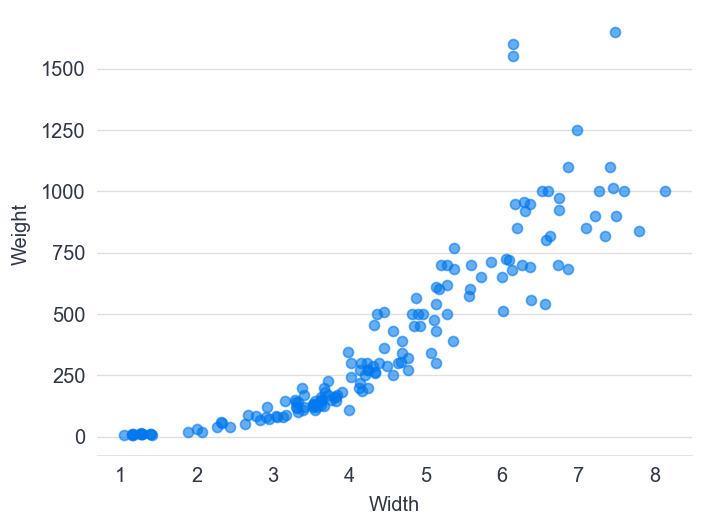

In [7]:
fig, ax = plt.subplots()
ax.scatter(data["Width"], data["Weight"], alpha=0.6);
ax.set(xlabel="Width", ylabel="Weight");

Definitely, the relationship is non-linear. A straight line in the untransformed space is not going to work very well.

Let's try again with the same log transformation we used along the lesson. 

We create a visualization with several panels because we show the different combinations of the transformations.

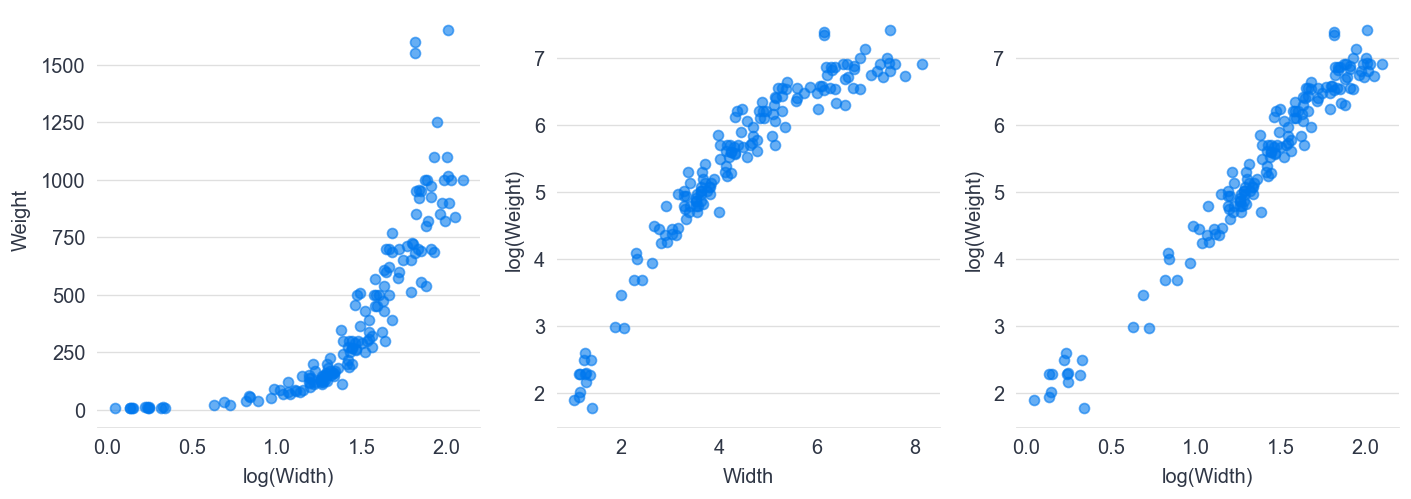

In [8]:
fig, axes = plt.subplots(ncols=3, figsize=(14, 4.5))

axes[0].scatter(np.log(data["Width"]), data["Weight"], alpha=0.6)
axes[0].set(xlabel="log(Width)", ylabel="Weight");

axes[1].scatter(data["Width"], np.log(data["Weight"]), alpha=0.6)
axes[1].set(xlabel="Width", ylabel="log(Weight)")

axes[2].scatter(np.log(data["Width"]), np.log(data["Weight"]), alpha=0.6)
axes[2].set(xlabel="log(Width)", ylabel="log(Weight)");

As it happened in the lesson, transforming both the predictor and the response is what gives us a relationship that can be well approximated by a straight line.

So we're going to be creating a simple linear regression model using $\log(\text{Width})$ as the predictor and $\log(\text{Weight})$ as the response.

In [9]:
log_width = np.log(data["Width"])
log_weight = np.log(data["Weight"])

with pm.Model() as model:
    β0 = pm.Normal("β0", mu=0, sigma=5)
    β1 = pm.Normal("β1", mu=0, sigma=5)
    sigma = pm.HalfNormal("sigma", sigma=5)
    mu = β0 + β1 * log_width
    pm.Normal("weight", mu=mu, sigma=sigma, observed=log_weight)
    idata = pm.sample(random_seed=1211)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β0, β1, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.


In [10]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
β0,1.543,0.071,1.420,1.693,0.003,0.002,686.0,550.0,1.0
β1,2.772,0.049,2.670,2.859,0.002,0.001,693.0,564.0,1.0
sigma,0.268,0.015,0.239,0.296,0.000,0.000,1027.0,1047.0,1.0


* R-hats are equal to 1 ✅
* ESS are good ✅
    * They could be better for β0 and β1, but they're not bad at all

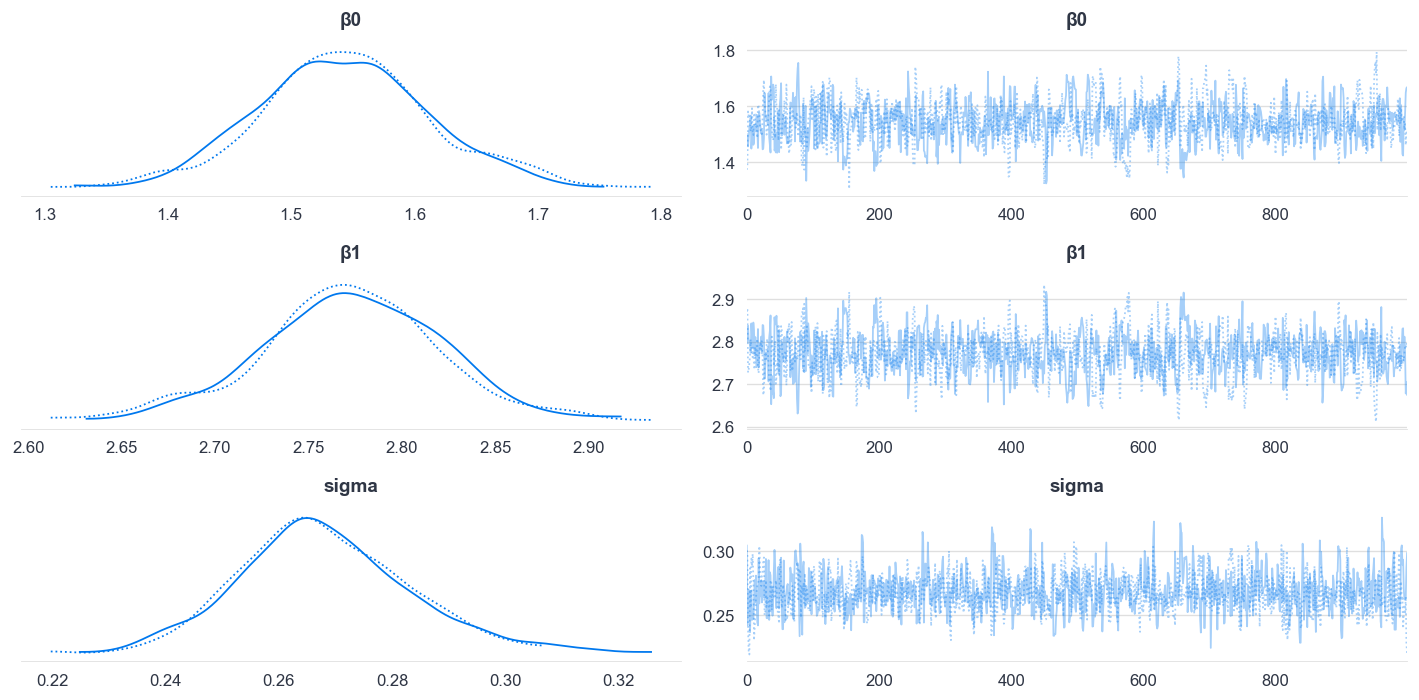

In [12]:
az.plot_trace(idata)
plt.tight_layout()

* All chains converge to the same posterior distribution ✅
* Traces show a white-noise pattern ✅

We can visualize the fit in the transformed space. Here we see the curve is a straight line.

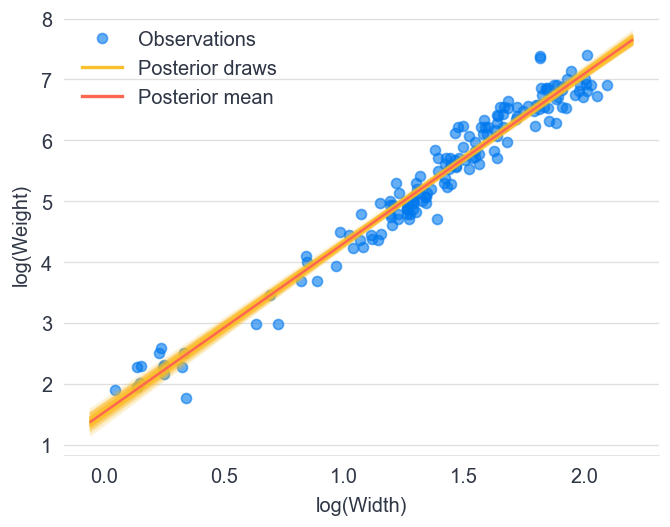

In [7]:
b0_draws = idata.posterior["β0"][:, ::10].to_numpy().flatten()
b1_draws = idata.posterior["β1"][:, ::10].to_numpy().flatten()

fig, ax = plt.subplots()
ax.scatter(log_width, log_weight, alpha=0.6)
ax.set(xlabel="log(Width)", ylabel="log(Weight)")

x_grid = np.array(ax.get_xlim())
for b0, b1 in zip(b0_draws, b1_draws):
    ax.plot(x_grid, b0 + b1 * x_grid, color="C1", alpha=0.1)

b0_mean = b0_draws.mean().item()
b1_mean = b1_draws.mean().item()
ax.plot(x_grid, b0_mean + b1_mean * x_grid, color="C4")

handles = [
    Line2D([], [], label="Observations", lw=0, marker="o", color="C0", alpha=0.6),
    Line2D([], [], label="Posterior draws", lw=2, color="C1"),
    Line2D([], [], label="Posterior mean", lw=2, color="C4"),
]
ax.legend(handles=handles, loc="upper left");

We can convert back to the original scale and we'll see here it's not a straight line anymore.

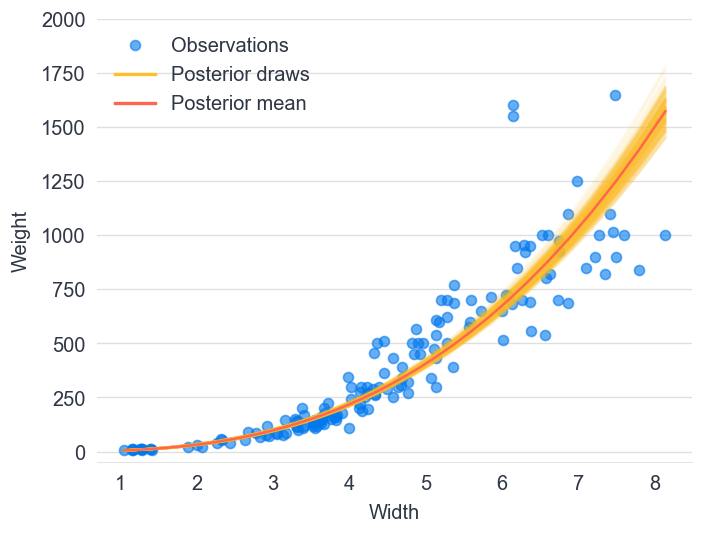

In [8]:
b0_draws = idata.posterior["β0"][:, ::10].to_numpy().flatten()
b1_draws = idata.posterior["β1"][:, ::10].to_numpy().flatten()

fig, ax = plt.subplots()
ax.scatter(data["Width"], data["Weight"], alpha=0.6)
ax.set(xlabel="Width", ylabel="Weight", ylim=(-50, 2000))

x_grid = np.linspace(log_width.min(), log_width.max())
for b0, b1 in zip(b0_draws, b1_draws):
    ax.plot(np.exp(x_grid), np.exp(b0 + b1 * x_grid), color="C1", alpha=0.1)

b0_mean = b0_draws.mean().item()
b1_mean = b1_draws.mean().item()
ax.plot(np.exp(x_grid), np.exp(b0_mean + b1_mean * x_grid), color="C4")

handles = [
    Line2D([], [], label="Observations", lw=0, marker="o", color="C0", alpha=0.6),
    Line2D([], [], label="Posterior draws", lw=2, color="C1"),
    Line2D([], [], label="Posterior mean", lw=2, color="C4"),
]
ax.legend(handles=handles, loc="upper left");

The fit looks much better than the one in the model we developed in "Section 60: Transformations". We see the line does not underestimates or overestimates the weight in a systematic manner. That's awesome!

Finall, we can check the residuals.

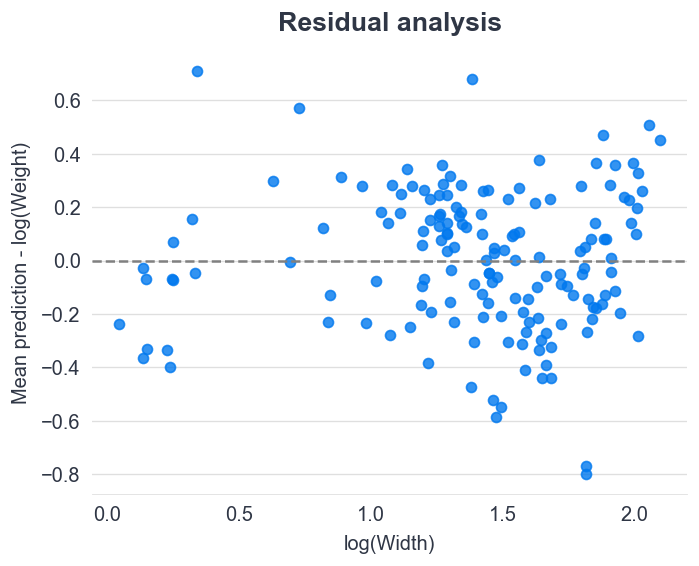

In [9]:
log_y_hat = b0_mean + b1_mean * log_width
log_residuals = log_y_hat - log_weight

fig, ax = plt.subplots()
ax.scatter(log_width, log_residuals, alpha=0.8);
ax.axhline(0, ls="--", color="0.5")
ax.set(
    xlabel="log(Width)", 
    ylabel="Mean prediction - log(Weight)", 
    title="Residual analysis"
);

The goodness we see in the curve fit is show here as well. There are no clear deviations from a random pattern anymore.

If we could only have used a single predictor, using Width looks more promising that Length!

## Exercise 2: What if we only use the species of fish?

In the lesson, we included the species variable as predictor in a model that already had a numerical predictor.

However, we didn't cover how a model that includes the species, but not the length, would look like. That's what this exercise is about!

You have to create a linear regression model using only the species of fish as predictor. Answer the following questions:

* Is there a slope parameter? 
* How many intercept parameters does the model have? Is it one, or more than one? Why?
* What is the meaning of the intercept parameter(s)?
* Is it necessary to transform the response variable?
* What's the difference between this model and the intercept-only model?

Finally, create a plot to show the regression line(s).

### Solution

We can simply take the model we created in "Section 70: Accounting for species" and remove anything related to continuous predictors. We just keep the part related to the intercepts. Also, since there are no numeric predictors, we can use the unstransformed variable.

$$
\begin{aligned}
\beta_{0,j} & \sim \text{Normal}(0, \sigma_{\beta_0}) \\
\sigma & \sim \text{HalfNormal}(\sigma_\varepsilon) \\
\mu_{i, j} & = \beta_{0,j}  \\
\text{Weight}_{i,j} & \sim \text{Normal}(\mu_{i, j}, \sigma)
\end{aligned}
$$

for $j=1, \cdots, 7$.

This model, which only uses the Species as predictor, it's like an intercept-only model. The difference is that now we have one intercept for every species, instead of a unique intercept for all.

In [63]:
weight = data["Weight"].to_numpy()
species, species_idx = np.unique(data["Species"], return_inverse=True)
coords = {"species": species}

with pm.Model(coords=coords) as model:
    β0 = pm.Normal("β0", mu=0, sigma=250, dims="species")
    sigma = pm.HalfNormal("sigma", sigma=100)
    mu = β0[species_idx]
    pm.Normal("weight", mu=mu, sigma=sigma, observed=weight)
    idata = pm.sample(random_seed=1211)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β0, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.


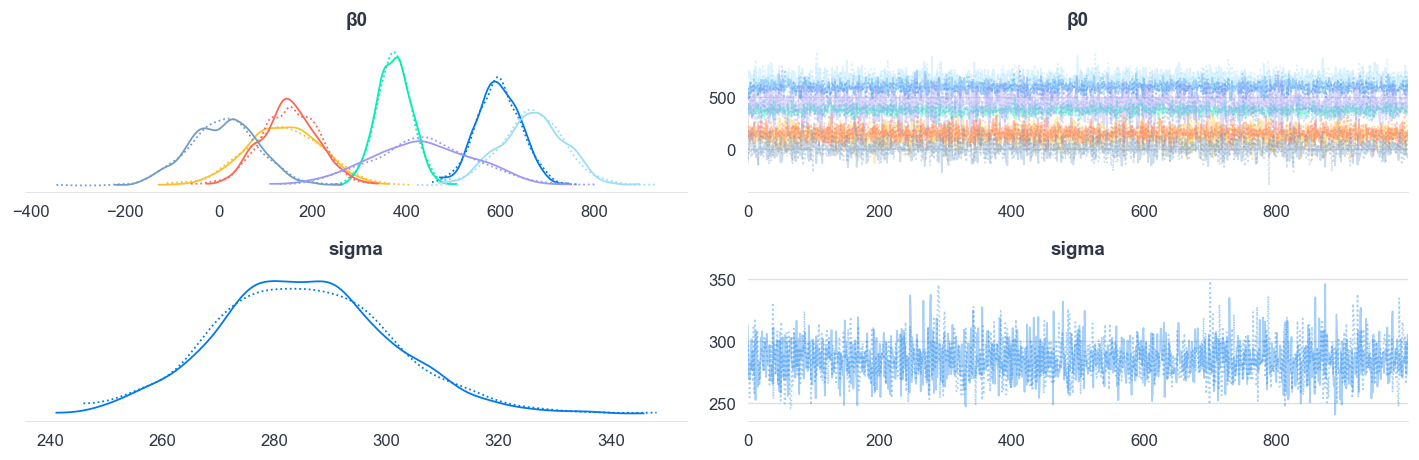

In [64]:
az.plot_trace(idata)
plt.tight_layout()

The basic sampling diagnostics don't show anything we should worry about. 

Let's compare the posterior distributions for each intercept with the mean weight of each species.

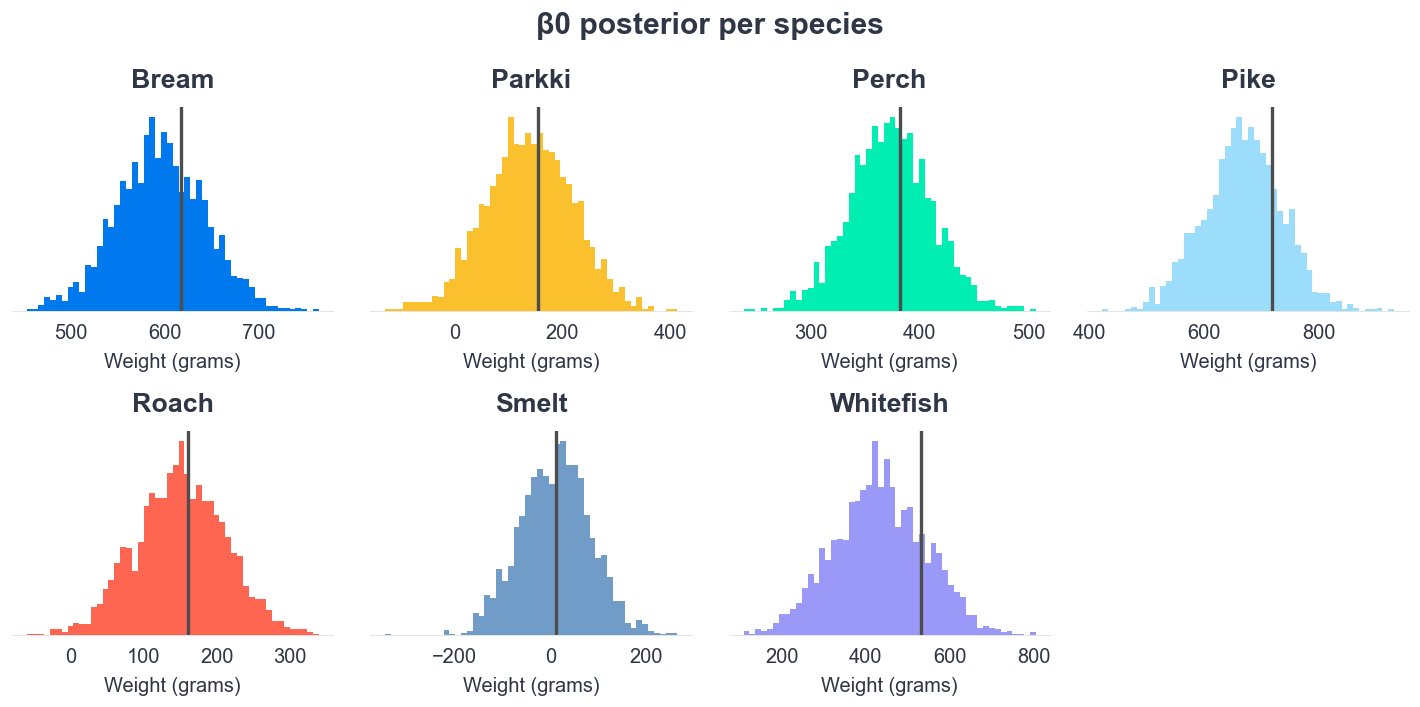

In [65]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6), tight_layout=True)
for i, (ax, species_name) in enumerate(zip(axes.ravel(), species)):
    values = idata.posterior["β0"].sel(species=species_name).to_numpy().flatten()
    mean_weight = np.mean(weight[species_idx == i])
    ax.hist(values, bins=50, color=f"C{i}")
    ax.axvline(mean_weight, color="0.3", lw=2)
    ax.set(xlabel="Weight (grams)", title=species_name)
    ax.get_yaxis().set_visible(False)

# Remove last panel
axes.ravel()[-1].remove()
fig.suptitle("β0 posterior per species");

There's a good and a bad part. The good part is that posteriors are located around the true mean weight of the groups. That's a great start!

However, some posteriors assign so much probability to negative values. This is something we could also see in the traceplot above.

This problem appears because we're using an unbounded likelihood, the Normal likelihood, for a bounded variable, the weight. 

Although using a transformation was not evident because we had no scatterplot to compare, we see it's important here as well.

Let's fit the model again, but this time transforming the weight into log(weight).

In [66]:
log_weight = np.log(data["Weight"].to_numpy())
species, species_idx = np.unique(data["Species"], return_inverse=True)
coords = {"species": species}

with pm.Model(coords=coords) as model:
    β0 = pm.Normal("β0", mu=0, sigma=3, dims="species")
    sigma = pm.HalfNormal("sigma", sigma=1)
    mu = β0[species_idx]
    pm.Normal("log(weight)", mu=mu, sigma=sigma, observed=log_weight)
    idata = pm.sample(random_seed=1211)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [β0, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.


$$
\begin{aligned}
\beta_{0,j} & \sim \text{Normal}(0, \sigma_{\beta_0}) \\
\sigma & \sim \text{HalfNormal}(\sigma_\varepsilon) \\
\mu_{i, j} & = \beta_{0,j}  \\
\log(\text{Weight}_{i,j}) & \sim \text{Normal}(\mu_{i, j}, \sigma)
\end{aligned}
$$

for $j=1, \cdots, 7$.

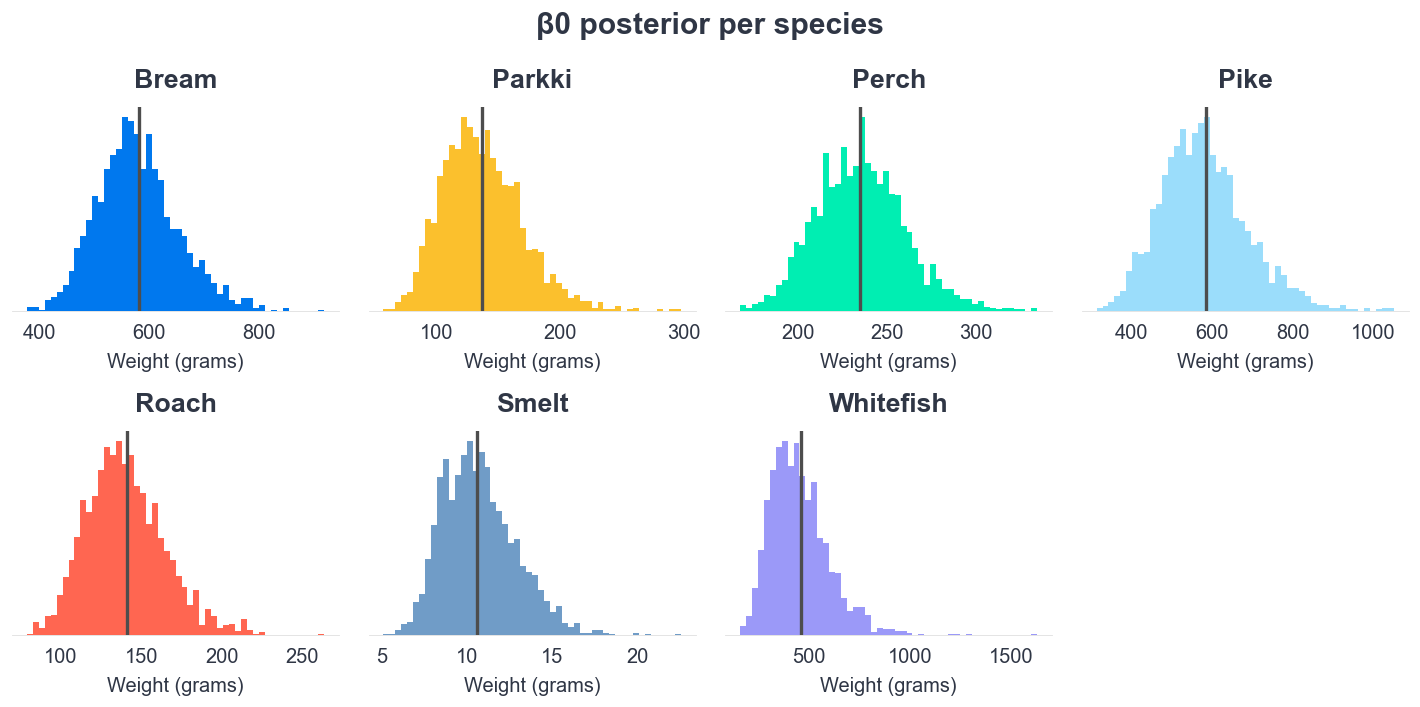

In [67]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6), tight_layout=True)
for i, (ax, species_name) in enumerate(zip(axes.ravel(), species)):
    values = np.exp(idata.posterior["β0"].sel(species=species_name).to_numpy().flatten())
    mean_weight = np.exp(np.mean(log_weight[species_idx == i]))
    ax.hist(values, bins=50, color=f"C{i}")
    ax.axvline(mean_weight, color="0.3", lw=2)
    ax.set(xlabel="Weight (grams)", title=species_name)
    ax.get_yaxis().set_visible(False)

# Remove last panel
axes.ravel()[-1].remove()

fig.suptitle("β0 posterior per species");

The result is so much better!! 

Not only the posteriors are centered around the true means, but they also respect the domain of the weight. Here, by design, the posteriors in the original scales are going to show positive values.

To summarize, let's answer the questions posted in the problem.

**Is there a slope parameter?** 

Nope. The model only has intercept coefficients as well as the dispersion parameter $\sigma$

**How many intercept parameters does the model have? Is it one, or more than one? Why?**

There are more than one intercept parameters. We have seven, because there's one for each species.

**What is the meaning of the intercept parameter(s)?**

The intercept parameters represent the mean weight of the species. In the most basic intercept-only model the intercept represented the mean weight of all fish. Now, they represent the mean weight per species.

**Is it necessary to transform the response variable?**

Yes. Because we need to map the response variable into an unbounded space. The log transformation does this. The transformation is not needed because of non-linearities in this case. 

**What's the difference between this model and the intercept-only model?**

This model contains one intercept per species, while the intercept-only model had one intercept for all. This model has more parameters and is more flexible.

## Exercise 3: Multiple intercepts, but a single slope

The model we created in "Section 70: Accounting for species" considers varying intercepts and slopes for every species. It is, every species had its own intercept and its own slope. We did this because we mentioned it was the most flexible approach. However, when we analyzed the posterior estimates we noticed the slope posteriors were all quite similar, meaning regression lines for the species were indeed parallel. Because of this, it makes sense to have a single slope parameter instead of multiple ones, which reduces the complexity of the model a little.

The goal of this exercise is to write a regression model with unpooled intercepts, one intercept per species, but a completely pooled slope -- a single, common, slope for all species. Consider the following points when solving the exercise

* Perform the same train-test split than in "Section 80: New fish arrive". 
* Build the model with a single slope, but multiple intercepts, using the train dataset.
* Predict the weight of the fish in the test set.
* Compare the predictions obtained here with the ones obtained in "Section 80: New fish arrive"

Also, do you notice any difference in sampling speed? Why? Is that what you were expecting?

**COMMENT:** I think we can include the loading of the data and the train-test split so we make sure it's clear we need to use the same seed so results are comparable with the ontes obatined in Section 80.

## Exercise 4: Test your skills with a brand new problem!

You work in the civil engineering department of a major university. You are part of a project testing the strength of concrete samples.

Concrete is the most widely used building material in the world. It is a mix of cement and water with gravel and sand. It can also include other materials like fly ash, blast furnace slag, and additives.

The compressive strength of concrete is a function of components and age, so your team is testing different combinations of ingredients at different time intervals.

The project leader asked you to find a simple way to estimate strength so that students can predict how a particular sample is expected to perform.

### The data

The team has already tested more than a thousand samples ([source](https://archive.ics.uci.edu/ml/datasets/concrete+compressive+strength))

This is a description of the variables

* **cement** - Portland cement in kg/m3
* **slag** - Blast furnace slag in kg/m3
* **fly_ash** - Fly ash in kg/m3
* **water** - Water in liters/m3
* **superplasticizer** - Superplasticizer additive in kg/m3
* **coarse_aggregate** - Coarse aggregate (gravel) in kg/m3
* **fine_aggregate** - Fine aggregate (sand) in kg/m3
* **age** - Age of the sample in days
* **strength** - Concrete compressive strength in megapascals (MPa)

### The challenge

Provide your project leader with a formula that estimates the compressive strength. Include:

* The coefficients $\beta_0, \cdots, \beta_8$ to use in the following formula:

$$
\text{Concrete Strenght} = \beta_0  + \beta_1 \text{cement} + \beta_2 \text{slag} + \beta_3 \text{fly ash} + \beta_4 \text{water} + \beta_5 \text{superplasticizer} + \beta_6 \text{coarse aggregate} + \beta_7 \text{fine aggregate} + \beta_8 \text{age}
$$

* The average strength of the concrete samples at 1, 7, 14, and 28 days of age.

**TODO** Cite the paper where we take data from. It's required by the authors.